<a href="https://colab.research.google.com/github/Jonathan-C-Barrett/GEOG5990M/blob/main/GEOG5003M_Final_Project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5003M Final Assignment (Template)

Student ID number:

GitHub repo link:

Word count limit= 1,500 words max (markdown cells only, excluding readme)

# Read in Packages

In [ ]:
# read in required packages

import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt

!pip install mapclassify

# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

# Data and Preprocessing

**HEALTH SERVICE ACCESS DATA**

In [ ]:
#Read in Health Services Data
ahah = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/ahah_v4.csv')
ahah.head()

In [ ]:
#Select only columns relating to Health Services
health = ahah[['LSOA21CD', 'ah4dent', 'ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h']]
health.head()

In [ ]:
#check for missing values
health.isna().sum()

**MEDIAN PROPERTY VALUE DATA**

In [ ]:
#Read in Median Property Price
m_value = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/land-registry-house-prices-Meidan-LSOA.csv')
m_value.head()

In [ ]:
#Select only columns relating to 2016
prop_16 = m_value[['Code', 'Area','Year ending Mar 2016','Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']]
prop_16.head()

In [ ]:
#examine property info for count and data type
prop_16.info()

In [ ]:
#check for missing values
prop_16.isna().sum()

In [ ]:
#create a column of mean year value to counter missing values
prop_16['2016_mean'] = prop_16[['Year ending Mar 2016', 'Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']].mean(axis=1)
prop_16.head()

In [ ]:
prop_16.isna().sum()

**LSOA 2011 TO LSOA 2021 COVERSION DATA**

In [ ]:
#add conversion to LSOA21
LSOA21 = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Best_Fit_Lookup_for_EW_(V2).csv')
LSOA21.head()


In [ ]:
#inspect info for data type
LSOA21.info()

In [ ]:
#combine prop_16 data and LSOA21 by code in prop_16 and LSOA11CD in LSOA21 in to remove areas outside london and make comparable
prop_16_LSOA21 = pd.merge(prop_16, LSOA21, left_on='Code', right_on='LSOA11CD', how='left')
prop_16_LSOA21.head()

In [ ]:
#check Info for count
prop_16_LSOA21.info()

**COMBINE HEALTH ACCESS AND PROPERTY VALUE DATABASES**

In [ ]:
#combine health and property data by LSOA code in property to remove areas outside london
health_prop = pd.merge(health, prop_16_LSOA21, left_on='LSOA21CD', right_on='LSOA21CD', how='right')
health_prop.head()

In [ ]:
#check info for data frame to check count and data type
health_prop.info()

In [ ]:
#check for missing values
health_prop.isnull().sum()

In [20]:
#remove missing values from Year mean column
health_prop = health_prop.dropna(subset=['2016_mean'])

In [ ]:
#Check removed 2016 Mean missing values
health_prop.isnull().sum()

In [ ]:
#remove duplicated and unneccessary columns from Data base
health_prop_clean = health_prop.drop(columns=['Code', 'Area', 'LSOA11NM', 'LSOA11CD', 'ObjectId','LAD22NMW', 'Year ending Mar 2016', 'Year ending Jun 2016','Year ending Sep 2016','Year ending Dec 2016', ])
health_prop_clean.head()


In [ ]:
#check data type and missing values of required columns
health_prop_clean.info()


**INVESTIGATE DISTRIBUTION OF DATA AND REMOVAL OF OUTLIERS**

In [ ]:
#check basic geometry of data
health_prop_clean.describe()

In [ ]:
#Explore correlation between property price mean and health service float data with pairplot
sns.pairplot(health_prop_clean[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']]);

In [ ]:
#check for outliers observed in pairplot
health_prop_clean['2016_mean'].nlargest(n=25)

In [ ]:
#use boxplot to inspect impact of outliers
sns.boxplot(data=health_prop_clean, x='2016_mean');
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)


In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4gp');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4hosp');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4leis');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4h');

In [32]:
#remove outliers in 2016 mean using interquartle range method
#find intterquartile range
Q1 = health_prop_clean['2016_mean'].quantile(0.25)
Q3 = health_prop_clean['2016_mean'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
#view Q1, Q3 and IQR
Q1, Q3, IQR

In [ ]:
#find upper and lower limits
upper_limit = Q3 + (1.5 * IQR)
lower_limit = Q1 - (1.5 * IQR)
lower_limit, upper_limit

In [ ]:
#find outliers
outliers = health_prop_clean[(health_prop_clean['2016_mean'] > upper_limit) | (health_prop_clean['2016_mean'] < lower_limit)]
outliers

In [36]:
#trim the data
health_prop_clean_trim = health_prop_clean[(health_prop_clean['2016_mean'] < upper_limit) & (health_prop_clean['2016_mean'] > lower_limit)]


In [ ]:
#check for difference in data
print('before removing outliers', health_prop_clean.shape)
print('after removing outliers', health_prop_clean_trim.shape)

# Data Exploration

**CORRELATION THROUGH SPEARMANS RANK**

In [ ]:
#Calculate Spearmans Rank Correlation for all float data

health_prop_corr =health_prop_clean_trim[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_corr


In [ ]:
#Visualize spearmans correlation

# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_corr))

# define axis labels
x_axis_labels = health_prop_corr.columns
y_axis_labels = health_prop_corr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_corr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in squares
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


**CLUSTERING OF DATA THROUGH K-MEANS CLUSTERING**

In [ ]:
#Decide on number of clusters through elbow method
# create an empty list
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15 create a k-means model with that number of clusters and set a random state
for k in K:
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables from health_prop_clean
    km = km.fit(health_prop_clean_trim[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
# run the model with minimum needed for minimal change in this instance 4
km4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(health_prop_clean_trim[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].values)


In [56]:
km4cls.labels_

array([3, 3, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
# Create a pairplot which shows relationship between variables captured by clustering
sns.pairplot(health_prop_clean[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean','cluster']],
             hue='cluster',
             palette='Dark2',
            height=5);

In [52]:
#create column of inner or outer borough for additional information in visualisation
inner_london_boroughs = ('Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster')

for index, row in health_prop_clean_trim.iterrows():
  if row['LAD22NM'] in inner_london_boroughs:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Inner Borough'
  else:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Outer Borough'

In [53]:
#check inner_outer has worked correctly
num_unique_categories = health_prop_clean_trim['inner_outer'].nunique()
print(f"Number of unique categories: {num_unique_categories}")

Number of unique categories: 2


# Non Spatial Visulation

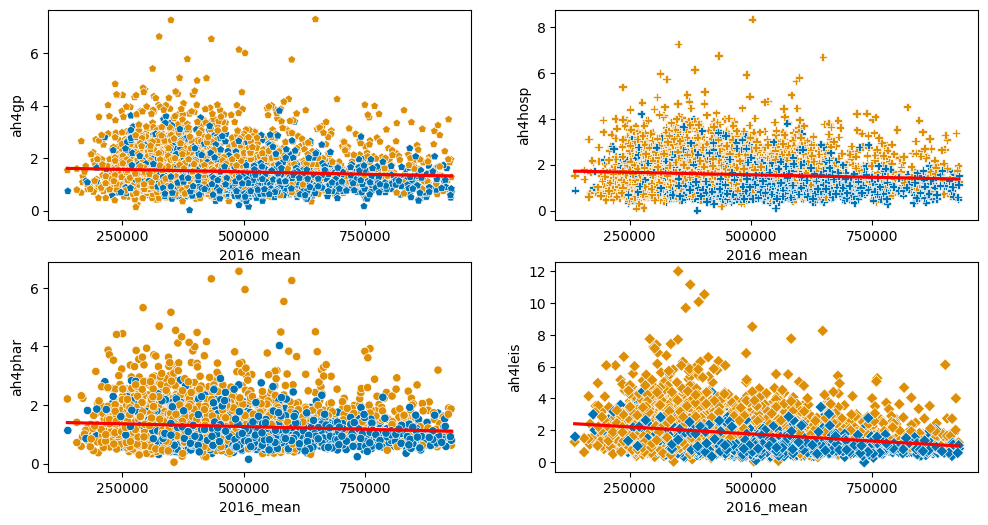

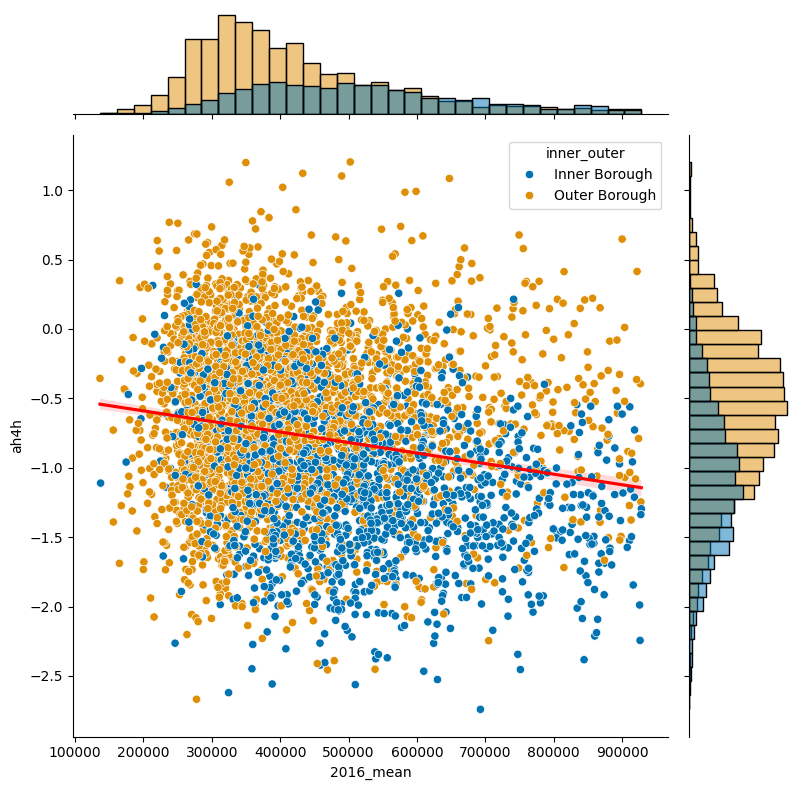

In [55]:
#create four subplots of health service individual variables
f,ax = plt.subplots(2,2, figsize=(12,6))


#plot distance to gp in plot 1
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4gp', hue='inner_outer', legend=False, marker= "p", palette='colorblind', ax=ax[0,0], ).locator_params(axis='x', nbins=3)
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4gp", scatter=False, ax=ax[0,0], color='red')



#plot distance to hospital in plot 2
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4hosp', hue='inner_outer', legend=False, marker= "P", palette='colorblind', ax=ax[0,1]).locator_params(axis='x', nbins=3)
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4hosp", scatter=False, ax=ax[0,1], color='red')



#plot distance to pharmacy in plot 3
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4phar', hue='inner_outer', legend=False,  marker= "o", palette='colorblind', ax=ax[1,0]).locator_params(axis='x', nbins=3)
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4phar", scatter=False, ax=ax[1,0], color='red')

#plot distance to leisure center in plot 4
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4leis', hue='inner_outer', legend=False,  marker= "D", palette='colorblind', ax=ax[1,1]).locator_params(axis='x', nbins=3)
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4leis", scatter=False, ax=ax[1,1], color='red')



#plot overal health access score vs property value
g=sns.JointGrid(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue="inner_outer", height =8)

#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4h", scatter=False, ax=g.ax_joint, color='red')

#remove scientific formating to include full house price
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

#plot health access score vs property value as scatter plot
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue='inner_outer', palette='colorblind', ax=g.ax_joint)

#plothistograms on x-axis showing distribution of house price
sns.histplot(data=health_prop_clean_trim, x='2016_mean', hue="inner_outer", palette='colorblind', ax=g.ax_marg_x)

#plot histogram on y-axis showing distribution of health access score
sns.histplot(data=health_prop_clean_trim, y='ah4h', hue="inner_outer", palette='colorblind', ax=g.ax_marg_y)

#Remove legend from axis histograms
g.ax_marg_y.legend_.remove()
g.ax_marg_x.legend_.remove()

# LOCAL AUTHORITY DISTRICT (LAD) VISUALISTAION

**COMBINING LAD BOUNDARY GEOMETRY AND HEALTH ACCESS Vs PROPERTY VALUE**

In [73]:
# Data downloaded from https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2024-boundaries-uk-bfe-2/explore?location=51.468470%2C-0.040938%2C9.90
shp = gpd.read_file('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/main/Local_Authority_Districts_May_2024_Boundaries_UK_BFE_2410925873296837173.geojson')



In [66]:
#inspect data
shp.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.6761,"POLYGON ((-1.26846 54.72612, -1.26822 54.72609..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.5447,"POLYGON ((-1.25112 54.59153, -1.24953 54.59151..."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.5675,"POLYGON ((-1.14063 54.64768, -1.13785 54.64757..."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.5569,"POLYGON ((-1.31729 54.6448, -1.31715 54.6448, ..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.5353,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,..."


In [74]:
#group property and health data by Local Authority District
health_prop_LAD = health_prop.groupby('LAD22NM').mean(numeric_only=True)
health_prop_LAD.head(n=35)

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,2016_mean,ObjectId
LAD22NM,,,,,,,,,,,,
Barking and Dagenham,1.598126,1.311151,1.365741,1.327178,2.209175,-0.696225,2.584390e+05,2.709088e+05,2.792480e+05,2.901355e+05,2.746140e+05,1094.280374
Barnet,1.352003,1.518061,1.984389,1.329101,1.583689,-0.716246,5.786375e+05,5.901272e+05,5.882688e+05,6.022404e+05,5.885737e+05,496.038095
Bexley,1.748908,1.916312,2.323867,1.519910,2.516622,-0.347685,3.119380e+05,3.207229e+05,3.312444e+05,3.383479e+05,3.243487e+05,575.152778
Brent,1.299495,1.390050,1.689441,1.179907,1.878520,-0.780274,4.821268e+05,4.937327e+05,4.995929e+05,5.060478e+05,4.920600e+05,1932.964497
Bromley,1.826762,1.884793,2.169753,1.789389,2.266581,-0.378507,4.279508e+05,4.375757e+05,4.474416e+05,4.583594e+05,4.427177e+05,1303.852792
Camden,1.018297,1.134781,1.087925,0.938498,1.015850,-1.296560,7.920687e+05,8.030095e+05,8.058825e+05,8.267873e+05,8.000290e+05,942.289062
City of London,0.701367,1.191683,1.003900,0.734433,0.464800,-1.641950,7.292458e+05,7.496667e+05,7.545833e+05,7.639167e+05,7.493531e+05,10560.833333
Croydon,1.661749,1.889034,1.810304,1.520836,2.247641,-0.534713,3.481414e+05,3.553971e+05,3.650222e+05,3.761989e+05,3.603886e+05,1173.958716
Ealing,1.327515,1.229889,1.595108,1.190168,1.822375,-0.846692,4.770921e+05,4.892466e+05,4.940729e+05,4.910485e+05,4.833447e+05,1827.448454


In [75]:
#explore basic statistics
health_prop_LAD.describe()

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,2016_mean,ObjectId
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000
mean,1.355739,1.452918,1.520347,1.240065,1.750378,-0.849673,5.238351e+05,5.360207e+05,5.447385e+05,5.554499e+05,5.375976e+05,3825.504868
std,0.338403,0.323215,0.369973,0.278643,0.638477,0.368234,2.318751e+05,2.353733e+05,2.347048e+05,2.352842e+05,2.323529e+05,2414.933017
min,0.701367,0.942867,0.939054,0.734433,0.464800,-1.641950,2.584390e+05,2.709088e+05,2.792480e+05,2.901355e+05,2.746140e+05,496.038095
25%,1.128376,1.191683,1.176003,1.034963,1.238573,-1.116652,3.863467e+05,3.984728e+05,4.076019e+05,4.209032e+05,4.029531e+05,2209.725275
50%,1.349200,1.390050,1.509864,1.272373,1.807775,-0.780274,4.770921e+05,4.892466e+05,4.940729e+05,4.930282e+05,4.833447e+05,3474.829545
75%,1.539174,1.744391,1.809367,1.411446,2.209175,-0.604550,5.786375e+05,5.901272e+05,5.882688e+05,6.022404e+05,5.885737e+05,4896.658537
max,2.184689,2.018141,2.323867,1.836399,3.219549,-0.213492,1.431778e+06,1.450638e+06,1.456213e+06,1.459845e+06,1.440046e+06,10560.833333


In [76]:
#Cobine property and Health access data with geoson LAD boundaries and check all 33 Boroughs present
health_prop_LAD_ldn = pd.merge(shp, health_prop_LAD, left_on='LAD24NM', right_on='LAD22NM', how='right')
health_prop_LAD_ldn.head(n=35)

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,geometry,ah4dent,...,ah4hosp,ah4phar,ah4leis,ah4h,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,2016_mean,ObjectId
0,265,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.5456,"POLYGON ((0.1481 51.59653, 0.14807 51.59636, 0...",1.598126,...,1.365741,1.327178,2.209175,-0.696225,2.584390e+05,2.709088e+05,2.792480e+05,2.901355e+05,2.746140e+05,1094.280374
1,266,E09000003,Barnet,,523473,191752,-0.218190,51.6111,"POLYGON ((-0.19987 51.67017, -0.19968 51.66986...",1.352003,...,1.984389,1.329101,1.583689,-0.716246,5.786375e+05,5.901272e+05,5.882688e+05,6.022404e+05,5.885737e+05,496.038095
2,267,E09000004,Bexley,,549202,175434,0.146212,51.4582,"POLYGON ((0.15928 51.50871, 0.15997 51.50869, ...",1.748908,...,2.323867,1.519910,2.516622,-0.347685,3.119380e+05,3.207229e+05,3.312444e+05,3.383479e+05,3.243487e+05,575.152778
3,268,E09000005,Brent,,519615,186465,-0.275680,51.5644,"POLYGON ((-0.26482 51.59827, -0.2647 51.59817,...",1.299495,...,1.689441,1.179907,1.878520,-0.780274,4.821268e+05,4.937327e+05,4.995929e+05,5.060478e+05,4.920600e+05,1932.964497
4,269,E09000006,Bromley,,542036,165707,0.039246,51.3727,"POLYGON ((0.03059 51.44432, 0.03063 51.4443, 0...",1.826762,...,2.169753,1.789389,2.266581,-0.378507,4.279508e+05,4.375757e+05,4.474416e+05,4.583594e+05,4.427177e+05,1303.852792
5,270,E09000007,Camden,,527491,184283,-0.162910,51.5430,"POLYGON ((-0.16598 51.57274, -0.16589 51.57272...",1.018297,...,1.087925,0.938498,1.015850,-1.296560,7.920687e+05,8.030095e+05,8.058825e+05,8.267873e+05,8.000290e+05,942.289062
6,264,E09000001,City of London,,532382,181358,-0.093510,51.5156,"POLYGON ((-0.09669 51.52319, -0.09668 51.52317...",0.701367,...,1.003900,0.734433,0.464800,-1.641950,7.292458e+05,7.496667e+05,7.545833e+05,7.639167e+05,7.493531e+05,10560.833333
7,271,E09000008,Croydon,,533922,164745,-0.077610,51.3660,"POLYGON ((-0.11136 51.42317, -0.11093 51.42315...",1.661749,...,1.810304,1.520836,2.247641,-0.534713,3.481414e+05,3.553971e+05,3.650222e+05,3.761989e+05,3.603886e+05,1173.958716
8,272,E09000009,Ealing,,517055,181959,-0.314100,51.5244,"POLYGON ((-0.34553 51.55843, -0.34551 51.55843...",1.327515,...,1.595108,1.190168,1.822375,-0.846692,4.770921e+05,4.892466e+05,4.940729e+05,4.910485e+05,4.833447e+05,1827.448454
9,273,E09000010,Enfield,,532831,196198,-0.081440,51.6489,"POLYGON ((-0.10576 51.69188, -0.10574 51.69182...",1.652414,...,1.809367,1.531547,2.017747,-0.524259,3.963985e+05,4.017378e+05,4.179380e+05,4.325887e+05,4.105975e+05,2209.725275


In [ ]:
#check data on leaflet map
health_prop_LAD_ldn.explore()

**EXPLORE CORRELATION AT LAD SCALE**

In [81]:
#Examine correlation between data at LAD level using Spearmans rank
health_prop_LADcorr = health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_LADcorr

,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
ah4gp,1.000000,0.751671,0.935829,0.850936,0.931484,-0.624332
ah4hosp,0.751671,1.000000,0.836898,0.799799,0.876337,-0.635695
ah4phar,0.935829,0.836898,1.000000,0.918115,0.978610,-0.674131
ah4leis,0.850936,0.799799,0.918115,1.000000,0.953877,-0.757353
ah4h,0.931484,0.876337,0.978610,0.953877,1.000000,-0.744987
2016_mean,-0.624332,-0.635695,-0.674131,-0.757353,-0.744987,1.000000


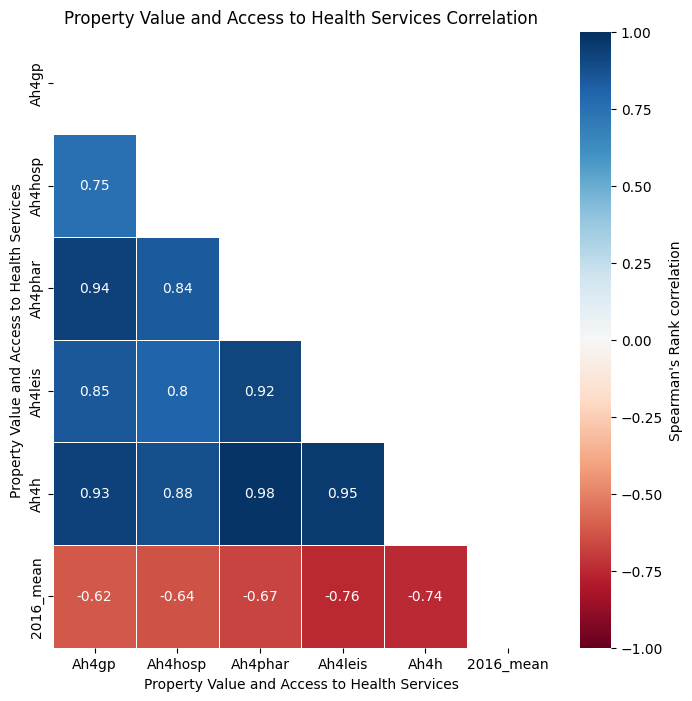

In [38]:
#visualise correlation
# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_LADcorr))

# define axis labels
x_axis_labels = health_prop_LADcorr.columns
y_axis_labels = health_prop_LADcorr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_LADcorr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in sqaures
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


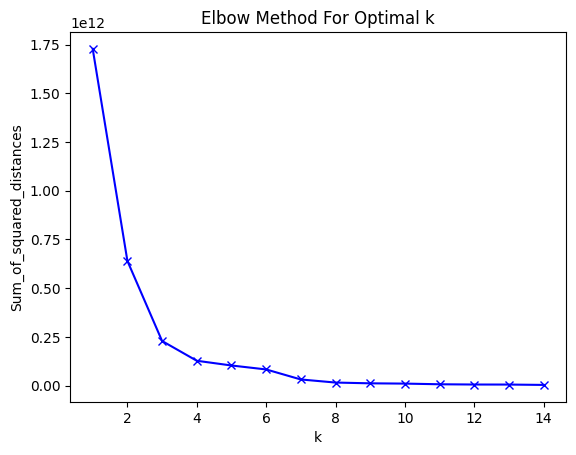

In [82]:
#Decide on number of clusters through elbow method
# create an empty list
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15create a k-means model with that number of clusters and set a random state
for k in K:
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables from database
    km = km.fit(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [84]:
# run the model with minimum needed for minimal change in this instance 4
km4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].values)

In [88]:
#create a new column in db with cluster label
health_prop_LAD_ldn['cluster'] = km4cls.labels_
health_prop_LAD_ldn['cluster'].head()

,cluster
0,2
1,0
2,2
3,0
4,0


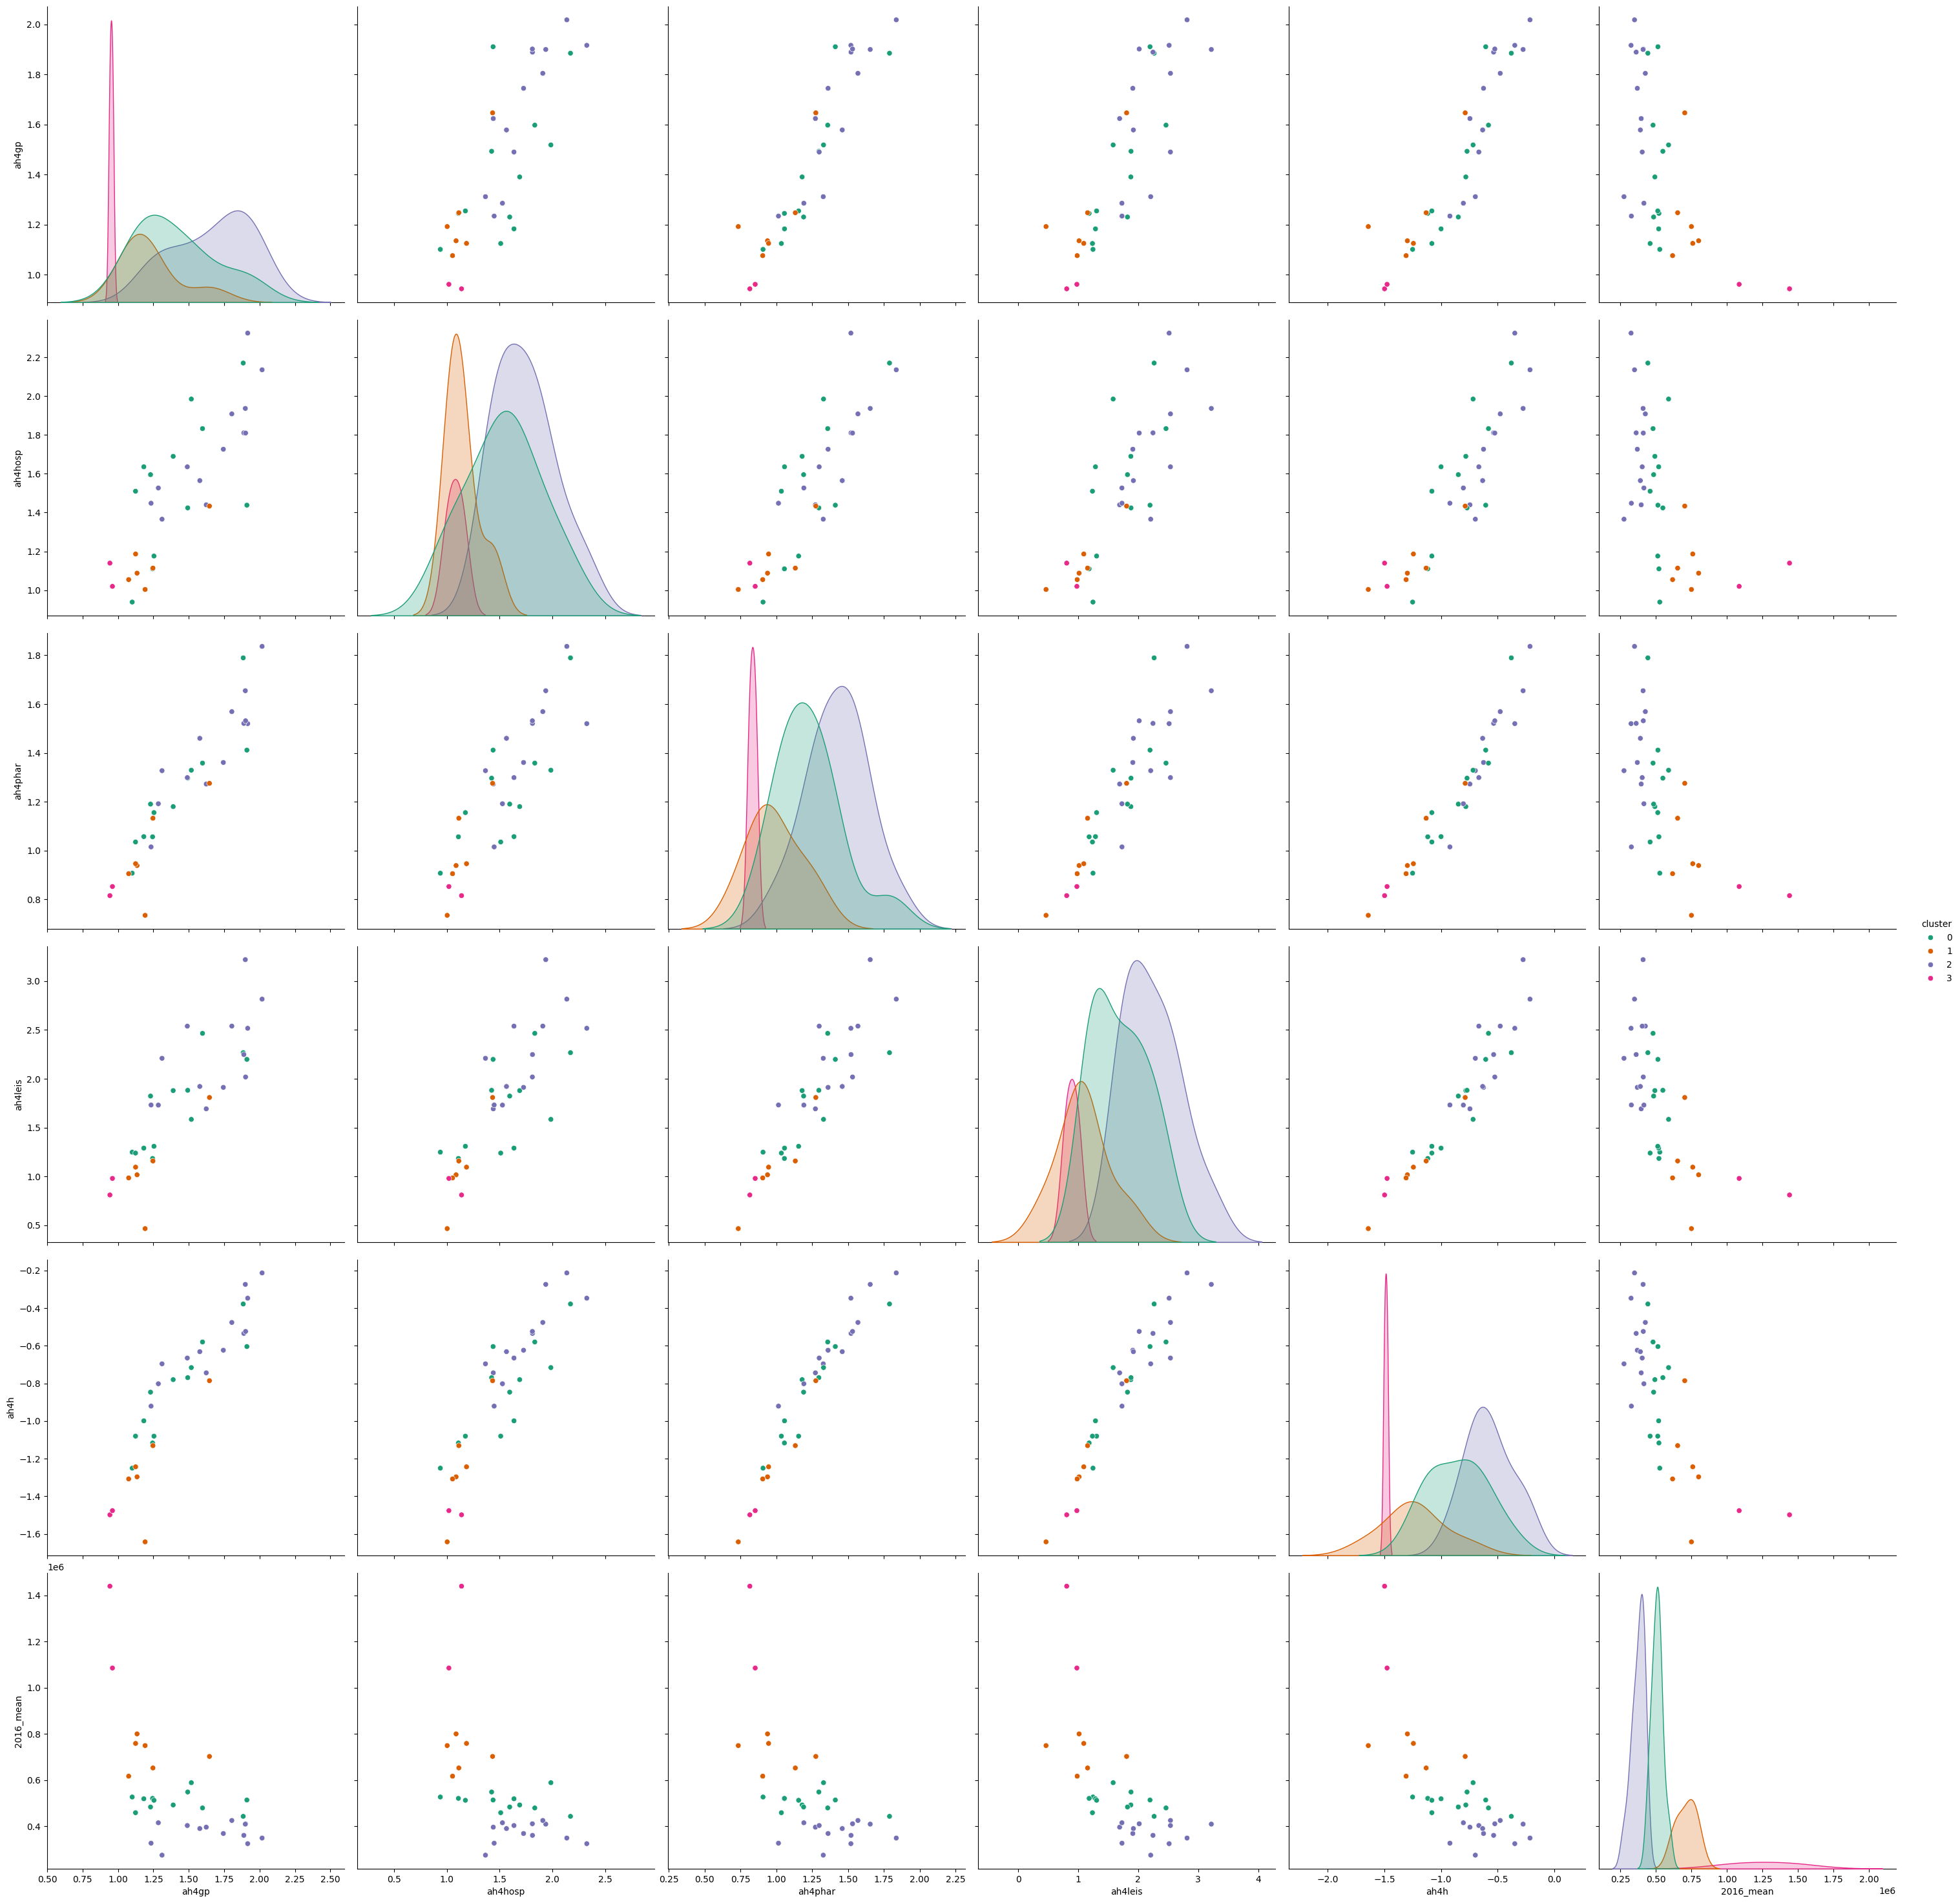

In [89]:
# Create a pairplot which shows relationship between variables captured by clustering
sns.pairplot(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean','cluster']],
             hue='cluster',
             palette='Dark2',
            height=5);

This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>